Данные по стартапу, который продает продукты питания. **Задача** - Нужно разобраться, как ведут себя пользователи приложения

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

Загружаем данные

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')

Смотрим на информацию и общий вид таблицы

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Начинаем подготовку данных.** Пропусков нет. В первую очередь переименуем столбцы для удобства

In [5]:
df.columns = ['event_name', 'device_id', 'event_timestamp', 'exp_group']

Переведем время совершения события в понятный нам формат

In [6]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [7]:
df.head()

,event_name,device_id,event_timestamp,exp_group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Выделим отдельно дату 

In [8]:
df['date'] = df['event_timestamp'].dt.strftime('%Y-%m-%d')

In [9]:
df.head()

,event_name,device_id,event_timestamp,exp_group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Подготовка данных завершена**

**Начинаем проверку и обработку данных**

In [10]:
df['event_name'].agg('nunique')

5

Всего 5 событий в данных. А сколько всего пользователей?

In [11]:
df['device_id'].agg('nunique')

7551

Около 3% от всех строк с данными. А сколько в среднем на одного пользователя приходится событий?

In [12]:
df.groupby('device_id').agg({'event_name': 'count'}).mean()

event_name    32.330287
dtype: float64

32 действия в среднем. Чтобы примерно понять, насколько это много или мало - посмотрим на взятый временной промежуток в данных

In [13]:
df['date'].min()

'2019-07-25'

In [14]:
df['date'].max()

'2019-08-07'

Взят двухнедельный промежуток. Стоит убедиться, что данные распределены равномерно

<AxesSubplot:title={'center':'Частота дат в текущем временно промежутке'}, xlabel='date', ylabel='event_timestamp'>

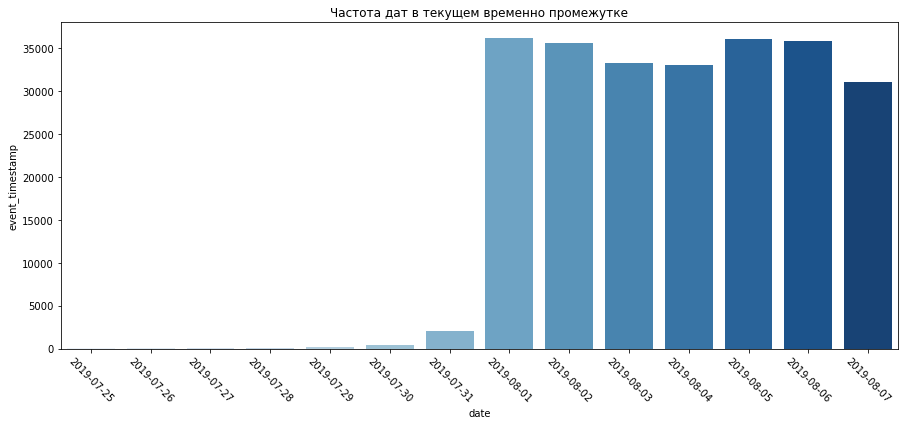

In [15]:
date_check_test = df.groupby('date').agg({'event_timestamp': 'count'}).reset_index()
plt.figure(figsize=(15, 6))
plt.xticks(rotation=315)
plt.title('Частота дат в текущем временно промежутке')
sns.barplot(data=date_check_test, x='date', y='event_timestamp', palette='Blues')

Видимо, до начала августа, она находилась в закрытой бете. Для исследования данных, приемлемо будет взять недельный промежуток с 1 по 8 августа

In [16]:
start_date = pd.to_datetime('2019-08-01', format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'])
df = df.query('date >= @start_date')
df['date'].value_counts().sum()

241298

Отбросили всего 3 тысячи из 244 тысяч, но зато теперь не будет явных искажений данных, связанных с первой неделей.

Тем не менее стоит проверить кол-во пользователей из каждых групп

In [17]:
df.groupby('exp_group')['device_id'].count()

exp_group
246    79425
247    77147
248    84726
Name: device_id, dtype: int64

Данные по всем трем группам присутствуют **Проверка и обработка данных завершена**

**Начинаем изучение воронки событий** Какие события есть в логах и как часто они встречаются

In [18]:
df.groupby(['event_name'])['device_id'].count().sort_values(ascending=False).reset_index()

,event_name,device_id
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


На первый взгляд неплохая конверсия от просмотра страницы с предложениями до перехода на страницу с вводом данных карты. И не очень обнадеживающий следующий этап до успешной оплаты.

Теперь посчитаем сколько пользователей совершали каждое из этих событий

In [19]:
every_user_event = df.groupby(['event_name']).agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False).reset_index()
every_user_event

,event_name,device_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Вряд ли концом воронки может быть обучение. Наверняка обучение проходится по желанию и далеко не все этим пользуются. Для воронки, нам стоит избавиться от этого события

In [20]:
funnel_data = df[df.event_name != 'Tutorial']
every_user_funnel_event = funnel_data.groupby(['event_name']).agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False).reset_index()
every_user_funnel_event

,event_name,device_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


Построим воронку событий

In [22]:
number = [7419, 4593, 3734, 3539]
labels = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
fig = go.Figure(
    go.Funnel(
        y = labels,
        x = number
    )
)
fig.show()

Судя по графику воронки: 1) с главного экрана до страницы c предложениями доходят почти **62%** уникальных пользователя. 

2) к странице с вводом данных карты доходят **81.3%** пользователей, что в среднем означает - **каждый восьмой** пользователь, зашедший на страницу с предложениями, переходит к оплате.

3) к странице с успешной оплатой переходят **94.8%** людей после страницы с вводом данных карт. 

Общий вывод: **Больше всего теряем пользователей к странице с предложениями** За счет чего теряем существенную группу потенциальных покупателей, ведь **от главного экрана до страницы с успешной оплаты доходят 47.7% пользователей**

**Изучение воронки событий завершено**

**Начинаем изучение результатов экспериментов**

In [23]:
funnel_data.head()

,event_name,device_id,event_timestamp,exp_group,date
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


Проверим в обновленных данных сколько людей в каждой группе

In [24]:
exp_overall_events = funnel_data.groupby('exp_group').agg({'device_id': 'nunique'}).reset_index()
exp_overall_events

,exp_group,device_id
0,246,2483
1,247,2512
2,248,2535


Примерно одинаково. Проверим гипотезу о равенстве долей событий по группам

In [32]:
exp_events = funnel_data.groupby(['exp_group', 'event_name']).agg({'device_id': 'nunique'}).sort_values(by=['device_id', 'event_name'], ascending=False).reset_index()
exp_events

,exp_group,event_name,device_id
0,248,MainScreenAppear,2493
1,247,MainScreenAppear,2476
2,246,MainScreenAppear,2450
3,246,OffersScreenAppear,1542
4,248,OffersScreenAppear,1531
5,247,OffersScreenAppear,1520
6,246,CartScreenAppear,1266
7,247,CartScreenAppear,1238
8,248,CartScreenAppear,1230
9,246,PaymentScreenSuccessful,1200


In [26]:
def exp_group_identity(p_value, alpha, arg):
    if arg == 1:
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями 246 и 247 есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными')
    elif arg == 2:
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями 247 и 248 есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными')
    elif arg == 3:
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями 246 и 248 есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными')

def function(row, successes0, successes1, trials0, trials1, arg):
    alpha=0.05
    p1 = successes0/trials0
    p2 = successes1/trials1
    p_combined = (successes0+successes1)/(trials0+trials1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/trials0+1/trials1))
    distr = st.norm(0, 1)
    p_value = (1-distr.cdf(abs(z_value))) * 2
    exp_group_identity(p_value, alpha, arg)

d = {
    'successes': [2450, 2476, 2493, 1542, 1520, 1531, 1266, 1238, 1230, 1200, 1158, 1181],
    'trials': [2483, 2512, 2535, 2450, 2476, 2493, 1542, 1520, 1531, 1266, 1238, 1230]
}
st_events = pd.DataFrame(data=d)
st_events.apply(
    function,
    args=(
        st_events['successes'][0], 
        st_events['successes'][1], 
        st_events['trials'][0], 
        st_events['trials'][1],
        1
    )
)
st_events.apply(
    function, 
    args=(
        st_events['successes'][1], 
        st_events['successes'][2], 
        st_events['trials'][1], 
        st_events['trials'][2],
        2
    )
)
st_events.apply(
    function,  
    args=(
        st_events['successes'][0], 
        st_events['successes'][2], 
        st_events['trials'][0], 
        st_events['trials'][2],
        3
    )
)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными


successes    None
trials       None
dtype: object

При статистической значимости в 5% **нет оснований полагать**, что между тремя долями есть разница от **общего кол-ва уникальных пользователей до пользователей, у кого появился главный экран**. Так и должно быть, посмотрим, что на следующих этапах.

In [27]:
st_events.apply(
    function,
    args=(
        st_events['successes'][3], 
        st_events['successes'][4], 
        st_events['trials'][3], 
        st_events['trials'][4],
        1
    )
)
st_events.apply(
    function, 
    args=(
        st_events['successes'][4], 
        st_events['successes'][5], 
        st_events['trials'][4], 
        st_events['trials'][5],
        2
    )
)
st_events.apply(
    function,  
    args=(
        st_events['successes'][3], 
        st_events['successes'][5], 
        st_events['trials'][3], 
        st_events['trials'][5],
        3
    )
)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными


successes    None
trials       None
dtype: object

Такие же результаты и по пользователям, которые **увидели главный экран** до пользователей, которые **перешли на страницу с предложениями** - нет оснований полагать, что доли разные

In [28]:
st_events.apply(
    function,
    args=(
        st_events['successes'][6], 
        st_events['successes'][7], 
        st_events['trials'][6], 
        st_events['trials'][7],
        1
    )
)
st_events.apply(
    function, 
    args=(
        st_events['successes'][7], 
        st_events['successes'][8], 
        st_events['trials'][7], 
        st_events['trials'][8],
        2
    )
)
st_events.apply(
    function,  
    args=(
        st_events['successes'][6], 
        st_events['successes'][8], 
        st_events['trials'][6], 
        st_events['trials'][8],
        3
    )
)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 247 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными


successes    None
trials       None
dtype: object

Идентичные результаты и по пользователям, которые **перешли на страницу с предложениями** до пользователей, которые **увидели страницу с вводом данных об оплате**. Нет оснований полагать, что доли разные

In [29]:
st_events.apply(
    function,
    args=(
        st_events['successes'][9], 
        st_events['successes'][10], 
        st_events['trials'][9], 
        st_events['trials'][10],
        1
    )
)
st_events.apply(
    function, 
    args=(
        st_events['successes'][10], 
        st_events['successes'][11], 
        st_events['trials'][10], 
        st_events['trials'][11],
        2
    )
)
st_events.apply(
    function,  
    args=(
        st_events['successes'][9], 
        st_events['successes'][11], 
        st_events['trials'][9], 
        st_events['trials'][11],
        3
    )
)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 247 разными
Отвергаем нулевую гипотезу: между долями 247 и 248 есть значимая разница
Отвергаем нулевую гипотезу: между долями 247 и 248 есть значимая разница
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли 246 и 248 разными


successes    None
trials       None
dtype: object

И вот первое несоответствие на последнем шаге. Между контрольными группами 246 и 247 нет значимых различий, **но в экспериментальной 248 группе есть значимая разница с контрольной группой 247**. Это **переход от страницы с вводом карты до страницы, уведомляющей об успещной оплате**

In [30]:
last_step_ratio246 = st_events['successes'][9] / st_events['trials'][9] 
last_step_ratio247 = st_events['successes'][10] / st_events['trials'][10]
last_step_ratio248 = st_events['successes'][11] / st_events['trials'][11] 
print('Конверсия последнего шага 246 группы: {:.3f}'.format(last_step_ratio246))
print('Конверсия последнего шага 247 группы: {:.3f}'.format(last_step_ratio247))
print('Конверсия последнего шага 248 группы: {:.3f}'.format(last_step_ratio248))

Конверсия последнего шага 246 группы: 0.948
Конверсия последнего шага 247 группы: 0.935
Конверсия последнего шага 248 группы: 0.960


Действительно - если между контрольными группами нет существенных различий, судя по проверке гипотезы и по абсолютным данным. То **между экспериментальной и второй контрольной группами - разница присутствует.**

Тем не менее, стоит ли считать эту разницу ощутимой, учитывая, что на предыдущих шагах нет значимой разницы, судя по статистической проверке? Вполне вероятно это могли быть выбросы. Поэтому для этого **нужны более точные данные, а именно событийная аналитика на странице с вводом данных о карте, чтобы делать более точные выводы.**